In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [156]:
data = pd.read_csv('data.csv')
data = data.sort_values(['itemDescription', 'Member_number'])
data = data[:5000]
print("there are {} unique item".format(data.itemDescription.unique().size))

there are 20 unique item


In [157]:
transactions = [a[1]['itemDescription'].tolist() for a in list(data.groupby(['Member_number']))]
max([len(i) for i in transactions])

8

In [158]:
MIN_SUPPORT=0.001
MIN_CONFIDENCE=0.001

In [159]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def Apriori(txns):
    te = TransactionEncoder()
    te_ary = te.fit(txns).transform(txns)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    start_time = time.time()
    freq_items = apriori(df, min_support=MIN_SUPPORT, use_colnames=True, verbose=1)
    freq_item_time = time.time() - start_time
    start_time = time.time()
    rules = association_rules(freq_items, metric="confidence", min_threshold=MIN_CONFIDENCE)
    rules_time = time.time() - start_time
    
    print("Time for frequent itemset generation:", freq_item_time)
    print("Time for high-confidence rules generation:", rules_time)
    return freq_item_time, rules_time

In [160]:
import time
from itertools import chain, combinations

def brute_force(txns):
    start_time = time.time()
    
    n = len(txns)
    w = max([len(i) for i in txns])
    unique_items = set(chain(*txns))
    d = len(unique_items)

    item_combinations = chain.from_iterable(combinations(unique_items, i) for i in range(d + 1))
    
    support_counts = {}
    
    for itemset in item_combinations:
        itemset_count = sum(1 for t in txns if set(itemset).issubset(t))
        support = itemset_count / n
        if support >= MIN_SUPPORT:
            support_counts[itemset] = support
    end_time = time.time()
    fi_time = end_time - start_time
    
    start_time = time.time()
    
    rules = []
    for itemset, support in support_counts.items():
        for i in range(1, len(itemset)):
            for lhs in combinations(itemset, i):
                lhs = set(lhs)
                rhs = set(itemset) - lhs
                
                support_lhs = sum(1 for t in txns if set(lhs).issubset(t)) / n
                support_itemset = sum(1 for t in txns if set(itemset).issubset(t)) / n
                confidence = support_itemset / support_lhs
                
                if support_itemset >= MIN_SUPPORT and confidence >= MIN_CONFIDENCE:
                    rules.append((lhs, rhs, support_itemset, confidence))
    # End time for rule generation
    end_time = time.time()
    rg_time=end_time - start_time

    print("Time taken for frequent itemset generation:",fi_time)
    print("Time taken for rule generation:", rg_time)
    return fi_time, rg_time, n, d, w


In [161]:
test_data=[tx for tx in transactions if len(tx) == 4]
for i in range(4):
    fi_time, rg_time, n, d, w = brute_force(test_data)
    fi_time_avg = (fi_time_avg * i + fi_time )/ (i + 1)
    rg_time_avg = (rg_time_avg * i + fi_time )/ (i + 1)
    
c_fi = fi_time_avg/n/pow(2,d)/w
c_rg = rg_time_avg/n/(pow(3,d)-pow(2,(d+1))+1)/w
print(c_fi)
print(c_rg)

Time taken for frequent itemset generation: 22.375396013259888
Time taken for rule generation: 0.31441569328308105
Time taken for frequent itemset generation: 25.850740909576416
Time taken for rule generation: 0.34311819076538086
Time taken for frequent itemset generation: 26.884285926818848
Time taken for rule generation: 0.35611677169799805
Time taken for frequent itemset generation: 27.38166093826294
Time taken for rule generation: 0.3565189838409424
1.58675434973206e-07
1.075115573908273e-10


In [162]:
def estimated_bf(transactions):
    n = len(transactions)
    w = max([len(i) for i in transactions])
    unique_items = set(chain(*transactions))
    d = len(unique_items)
    
    fi_time=c_fi*n*pow(2,d)*w
    rg_time=c_rg*(pow(3,d)-pow(2,(d+1))+1)*n*w
    
    return fi_time,rg_time

In [163]:
dataset_index = [50, 100, 200, 400, 800]
apriori_fi_times = []
apriori_rg_times = []
bf_fi_times = []
bf_rg_times = []
ns = []
for size in dataset_index:
    txns = transactions[:size]
    n=len(txns)
    print(f"Dataset with {n} transactions")
    apriori_fi_time, apriori_rg_time= Apriori(txns)
    bf_fi_time, bf_rg_time= estimated_bf(txns)
    print('----------------------------------------------------------------------')
    apriori_fi_times.append(apriori_fi_time)
    apriori_rg_times.append(apriori_rg_time)
    bf_fi_times.append(bf_fi_time)
    bf_rg_times.append(bf_rg_time)
    ns.append(n)

Dataset with 50 transactions
Processing 50 combinations | Sampling itemset size 54
Time for frequent itemset generation: 0.010062932968139648
Time for high-confidence rules generation: 0.004544973373413086
----------------------------------------------------------------------
Dataset with 100 transactions
Processing 110 combinations | Sampling itemset size 5
Time for frequent itemset generation: 0.01104426383972168
Time for high-confidence rules generation: 0.004682302474975586
----------------------------------------------------------------------
Dataset with 200 transactions
Processing 18 combinations | Sampling itemset size 654
Time for frequent itemset generation: 0.007901906967163086
Time for high-confidence rules generation: 0.005938291549682617
----------------------------------------------------------------------
Dataset with 400 transactions
Processing 48 combinations | Sampling itemset size 654
Time for frequent itemset generation: 0.010249853134155273
Time for high-confidenc

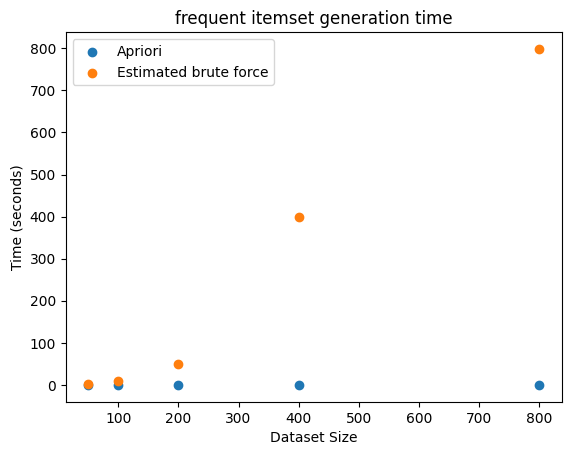

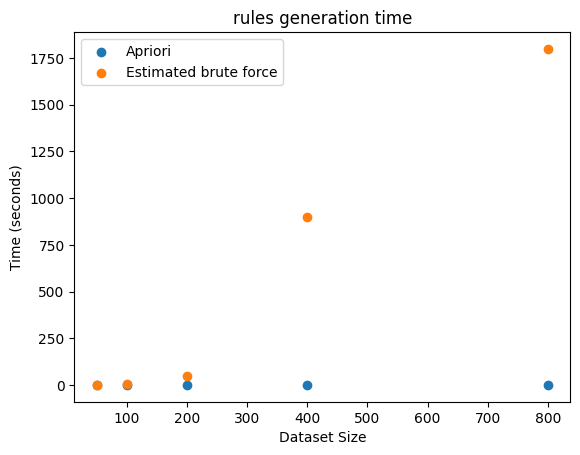

In [166]:
#plot time on large datasets

def plot(times_1, times_2, dataset_len, title ):
  # plot the measured time and the estimated time
  plt.scatter(dataset_len, times_1, label="Apriori")
  plt.scatter(dataset_len, times_2, label="Estimated brute force")
  plt.title(title)
  plt.xlabel("Dataset Size")
  plt.ylabel("Time (seconds)")
  plt.legend()
  plt.show()

plot(apriori_fi_times, bf_fi_times, ns, 'frequent itemset generation time')
plot(apriori_rg_times, bf_rg_times, ns, 'rules generation time')